In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Propagation
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.geometry import circle
from prysm.wavelengths import HeNe
from prysm.propagation import Wavefront, focus_fixed_sampling, unfocus_fixed_sampling

# from prysm.polynomials import hopkins

In [ ]:
# eres the jones pupil
pth = '/Users/jashcraft/Desktop/poke/ELT_Paper_1/ELT/Jones_Pupils/ELT_BareAg_658.fits'
jones = fits.open(pth)[0].data[...,0] + 1j* fits.open(pth)[0].data[...,1]
jones = jones[...,:2,:2]

def JonesToFocus(jones,dxp,dxi):

    efl = 100

    J11 = jones[...,0,0]
    J12 = jones[...,0,1]
    J21 = jones[...,1,0]
    J22 = jones[...,1,1]

    # use focus fixed sampling
    A11 = focus_fixed_sampling(J11,dxp,efl,0.658e-6,dxi,256)
    A12 = focus_fixed_sampling(J12,dxp,efl,0.658e-6,dxi,256)
    A21 = focus_fixed_sampling(J21,dxp,efl,0.658e-6,dxi,256)
    A22 = focus_fixed_sampling(J22,dxp,efl,0.658e-6,dxi,256)

    img = np.abs(A11 + A12)**2 + np.abs(A21 + A22)**2

    return img

(2, 2, 256, 256)
moving axis for matrix broadcasting
(256, 256, 2, 2)


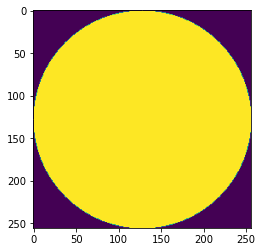

In [111]:
# Try program up the polarimetry stuff using prysm's coordinates
xi, eta = make_xy_grid(256, diameter=2)
dx = xi[1,0]-xi[0,0]
r, p = cart_to_polar(xi, eta)
A = circle(1, r)
plt.imshow(A)

# initial conditions
m = 3 # planes of symmetry parameter, trifold is most common
c = 2*1.75*np.pi # "constant proportional to external applied forces"
B = (2-m)/2
t = 2*B*p

ret = c*np.power(r,m-2) #np.pi/658e-9

# c = ret
# realcomp = np.cos(0.5*c*r**(m-2))
# # realcomp = np.cos(ret/2)


# imagcomp = 1j*np.sin(0.5*c*r**(m-2))#*(2*(2-m)*p)
# # imagcomp = 1j*np.sin(ret/2)*(2*t)


realcomp = np.cos(ret/2) * (r*0 + 1)
imagcomp = 1j*np.sin(ret/2)

real = np.array([[realcomp,0*realcomp],
                 [0*realcomp,realcomp]])
imag = np.array([[imagcomp*np.cos(t),-imagcomp*np.sin(t)],
                 [-imagcomp*np.sin(t),-imagcomp*np.cos(t)]])



J = real + imag
J *= A
print(J.shape)
print('moving axis for matrix broadcasting')
J = np.moveaxis(J,0,-1)
J = np.moveaxis(J,0,-1)
print(J.shape)

(256, 256, 2, 2)
0 0
0 1
1 0
1 1
0 0
0 1
1 0
1 1


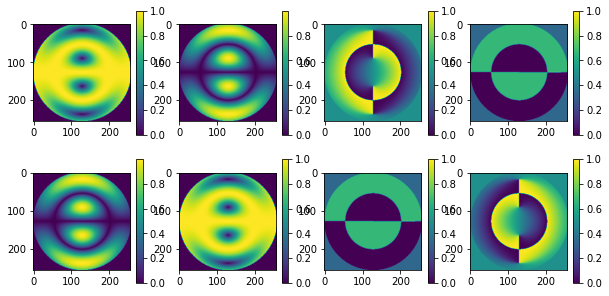

In [112]:
def plotjones(j):
    
    fig,ax = plt.subplots(ncols=4,nrows=2,figsize=[10,5])
    absj = np.abs(j)
    angj = np.angle(j)
    
    print(angj.shape)
    
    for a in range(2):
        for i in range(2):
            for j in range(2):

                print(i,j)

                if a == 0:
                    cmap = ax[i,j].imshow(absj[...,i,j])
                    fig.colorbar(cmap,ax=ax[i,j])
                else:
                    ax[i,j+2].imshow(angj[...,i,j])
                    fig.colorbar(cmap,ax=ax[i,j+2])
    
    plt.show()
    
plotjones(J)

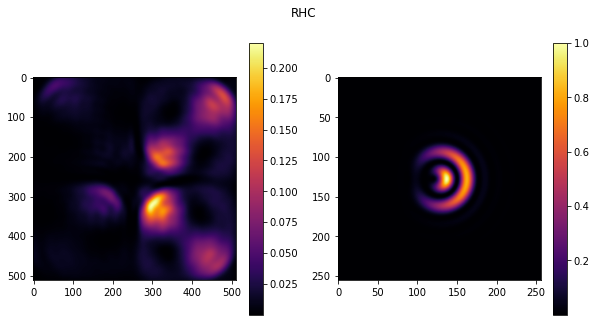

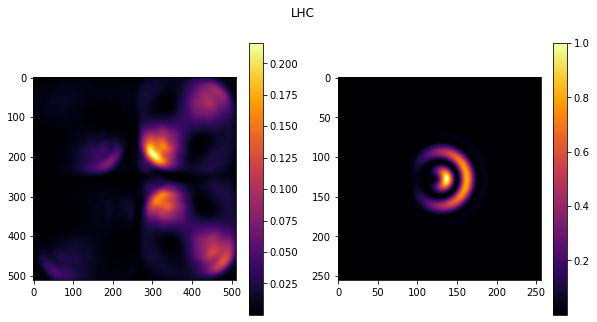

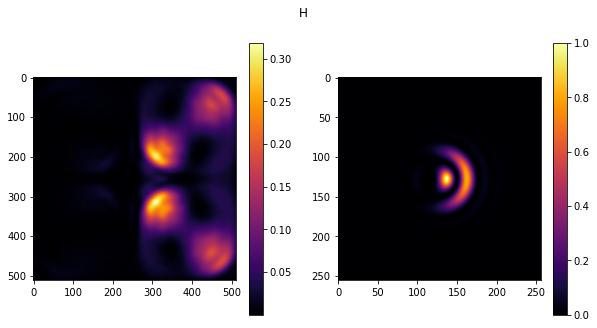

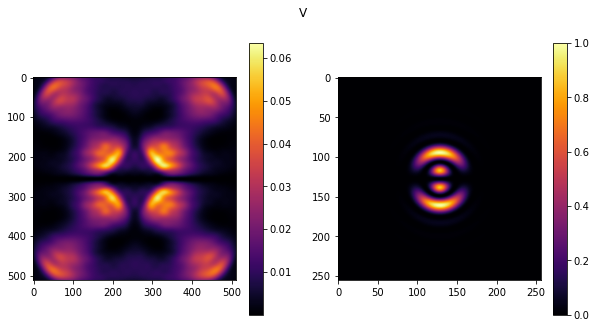

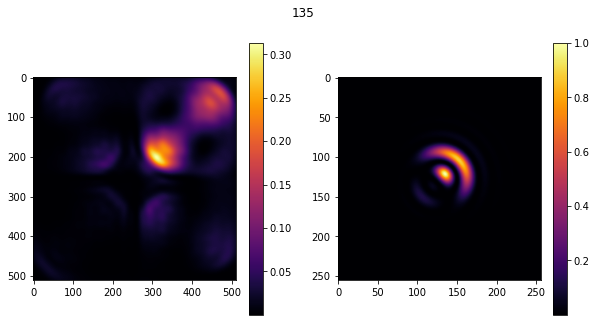

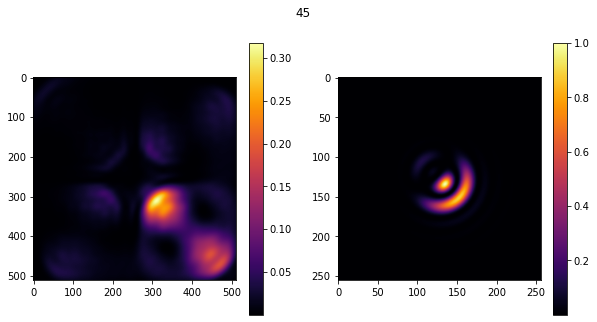

In [108]:
Ein = 0

def PropThruPyramid(Ein,label):

    # normalize
    Ein /= np.linalg.norm(Ein)

    RHC = np.array([[1,1j],[-1j,1]])
    LHC = np.array([[1,1j],[-1j,1]])
    HPol = np.array([[1,0],[0,0]])
    
    Ja = HPol @ J
    # Ja = RHC @ (J*0 + np.identity(2))
    Ja[...,0,0] *= A
    Ja[...,0,1] *= A
    Ja[...,1,0] *= A
    Ja[...,1,1] *= A


    # Eout1 = Ein[0]*Ja[...,0,0] + Ein[1]*Ja[...,0,1]
    # Eout2 = Ein[0]*Ja[...,1,0] + Ein[1]*Ja[...,1,1]

    dxp = 1/256
    dxi = 1e-3/256
    efl = 100

    # A1 = focus_fixed_sampling(Eout1,dxp,efl,0.658e-6,dxi,256)
    # A2 = focus_fixed_sampling(Eout2,dxp,efl,0.658e-6,dxi,256)

    A11 = focus_fixed_sampling(Ja[...,0,0]*Ein[0],dxp,efl,0.658e-6,dxi,256)
    A12 = focus_fixed_sampling(Ja[...,0,1]*Ein[1],dxp,efl,0.658e-6,dxi,256)
    A21 = focus_fixed_sampling(Ja[...,1,0]*Ein[0],dxp,efl,0.658e-6,dxi,256)
    A22 = focus_fixed_sampling(Ja[...,1,1]*Ein[1],dxp,efl,0.658e-6,dxi,256)

    image = np.abs(A11 + A12)**2 + np.abs(A21 + A22)**2
    image /= np.max(image)

    # image = np.abs(A1)**2 + np.abs(A2)**2
    # image /= np.sum(image)

    # total = np.abs(A11 + A12)**2 + np.abs(A21 + A22 + 1)**2
    # total /= np.sum(total)

    # plt.figure(figsize=[10,5])
    # plt.subplot(121)
    # plt.title('PSF of J = {}'.format(Ein))
    # plt.imshow((image),cmap='inferno')
    # plt.colorbar()

    # plt.subplot(122)
    # plt.title('PSF of Jones Pupil')
    # plt.imshow((total),cmap='inferno')
    # plt.colorbar()
    # plt.show()

        # Make a Pyramid Phase Ramp
    pyramid = np.zeros([256,256])
    shape = int(pyramid.shape[0]/2)
    x = np.linspace(-1,1,shape)
    X,Y = np.meshgrid(x,x)

    pyramid[0:shape,0:shape] =   X + Y
    pyramid[shape:,shape:]   = - X - Y
    pyramid[0:shape,shape:]  = - X + Y
    pyramid[shape:,0:shape]  =   X - Y

    pyphasor = np.exp(1j*2*np.pi*pyramid*2)

    # pyramid[0:shape,0:shape] = X - Y
    # pyramid[0:shape,0:shape] = - X + Y

    # plt.figure()
    # plt.title('Pyramid Phase')
    # plt.imshow(np.angle(pyphasor),cmap='coolwarm')
    # plt.colorbar()
    # plt.show()

    P11 = unfocus_fixed_sampling(A11*pyphasor,dxi,efl,0.658e-6,dxp,256*2)
    P12 = unfocus_fixed_sampling(A12*pyphasor,dxi,efl,0.658e-6,dxp,256*2)
    P21 = unfocus_fixed_sampling(A21*pyphasor,dxi,efl,0.658e-6,dxp,256*2)
    P22 = unfocus_fixed_sampling(A22*pyphasor,dxi,efl,0.658e-6,dxp,256*2)

    pypupil = np.abs(P11 + P12)**2 + np.abs(P21 + P22)**2

    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.imshow((pypupil),cmap='inferno')
    plt.colorbar()

    plt.subplot(122)
    plt.suptitle(label)
    plt.imshow((image),cmap='inferno')
    plt.colorbar()
    plt.show()

    # Now build the reconstruction
    M11 = np.cos(ret/2)**2 + np.sin(ret/2)**2 * np.cos(2*t) 
    M12 = np.sin(ret/2)**2 * np.sin(2*t)
    M13 = np.sin(ret)*np.sin(t)

    # nested loop to build up the pixels
    offset = int(pypupil.shape[0]/2)
    vcube = np.empty([offset,offset,4])
    mcube = np.empty([offset,offset,4,4])
    # for i in range(int(pypupil.shape[0]/2)):
    #     for j in range(int(pypupil.shape[1]/2)):




            # pixel iteration
                    



PropThruPyramid(np.array([1.,-1j]),label='RHC')
PropThruPyramid(np.array([1.,1j]),label='LHC')
PropThruPyramid(np.array([1.,0]),label='H')
PropThruPyramid(np.array([0,1.]),label='V')
PropThruPyramid(np.array([1.,-1.]),label='135')
PropThruPyramid(np.array([1.,1.]),label='45')

In [105]:
# So we can't actually use a pyramid wavefront sensor to disambiguate, but maybe we can use the same idea with a pair of walloston prisms

Hpol = np.array([[1,1,0,0],
                 [1,1,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])/2
Vpol = np.array([[1,-1,0,0],
                 [-1,1,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])/2
Ppol = np.array([[1,0,1,0],
                 [0,0,0,0],
                 [1,0,1,0],
                 [0,0,0,0]])/2
Mpol = np.array([[1,0,-1,0],
                 [0,0,0,0],
                 [-1,0,1,0],
                 [0,0,0,0]])/2
Rpol = np.array([[1,0,0,1],
                 [0,0,0,0],
                 [0,0,0,0],
                 [1,0,0,1]])/2
Lpol = np.array([[1,0,0,-1],
                 [0,0,0,0],
                 [0,0,0,0],
                 [-1,0,0,1]])/2

def GeneralDiattenuator(dH,d45,dR):

    # Normalize the Diattenuation
    norm = np.sqrt(dH**2 + d45**2 + dR**2)
    dH /= norm
    d45 /= norm
    dR /= norm

    return np.array([[1,dH,d45,dR],
                     [dH,dH**2,dH*d45,dH*dR],
                     [d45,dH*d45,d45**2,d45*dR],
                     [dR,dH*dR,dR*d45,dR**2]])

def RotationMatrix4(t):
    return np.array([[1,0,0,0],
                     [0,np.cos(2*t),-np.sin(2*t),0],
                     [0,np.sin(2*t),np.cos(2*t),0],
                     [0,0,0,1]])

arbpol1 = RotationMatrix4(np.pi/8) @ Hpol @ RotationMatrix4(-np.pi/8)
arbpol2 = RotationMatrix4(np.pi/8) @ Vpol @ RotationMatrix4(-np.pi/8)
arbpol3 = RotationMatrix4(np.pi/8) @ Mpol @ RotationMatrix4(-np.pi/8)
arbpol4 = RotationMatrix4(np.pi/8) @ Ppol @ RotationMatrix4(-np.pi/8)

print(arbpol1/arbpol1[0,0])
print(arbpol2/arbpol2[0,0])
print(arbpol3/arbpol3[0,0])
print(arbpol4/arbpol4[0,0])

# pol1 = GeneralDiattenuator(1,1,0)
# pol2 = GeneralDiattenuator(1,-1,0)
# pol3 = GeneralDiattenuator(-1,1,0)
# pol4 = GeneralDiattenuator(-1,-1,0)

# print(pol1)
# print(pol2)
# print(pol3)
# print(pol4)

# pupil1 = Mpol @ Hpol #@ Rpol
# pupil2 = Ppol @ Vpol #@ Rpol
# pupil3 = Mpol @ Hpol #@ Rpol
# pupil4 = Ppol @ Vpol #@ Rpol
# print(pupil1)
# print(pupil2)
# print(pupil3)
# print(pupil4)

[[1.         0.70710678 0.70710678 0.        ]
 [0.70710678 0.5        0.5        0.        ]
 [0.70710678 0.5        0.5        0.        ]
 [0.         0.         0.         0.        ]]
[[ 1.         -0.70710678 -0.70710678  0.        ]
 [-0.70710678  0.5         0.5         0.        ]
 [-0.70710678  0.5         0.5         0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 1.          0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.5        -0.5         0.        ]
 [-0.70710678 -0.5         0.5         0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 1.         -0.70710678  0.70710678  0.        ]
 [-0.70710678  0.5        -0.5         0.        ]
 [ 0.70710678 -0.5         0.5         0.        ]
 [ 0.          0.          0.          0.        ]]


True Stokes Vector ----------
(0.9999999999999998, 0.0, 0.9999999999999998, 0.0)
-----------------------------


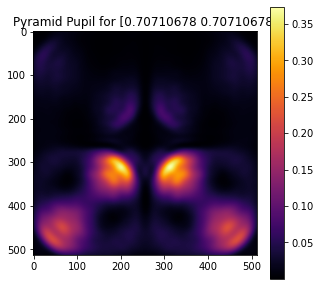

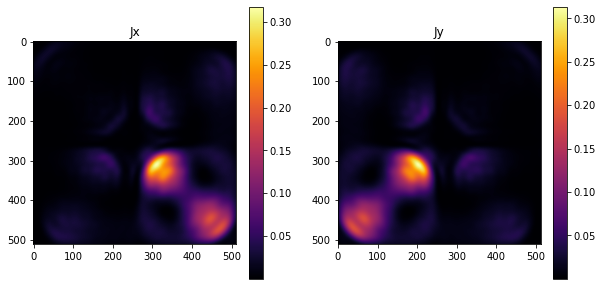

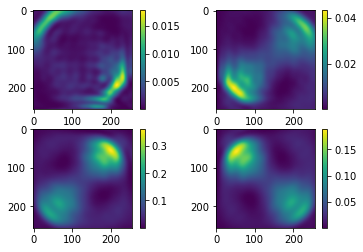

(256, 256, 4)
[[ 1.        ]
 [-0.76071186]
 [ 1.1557998 ]
 [-0.21574141]]


In [169]:
def JonesToStokes(jones):

    jx = jones[0]
    jy = jones[1]

    I = np.abs(jx)**2 + np.abs(jy)**2
    Q = np.abs(jx)**2 - np.abs(jy)**2
    U = 2*np.real(jx*np.conj(jy))
    V = 2*np.imag(jx*np.conj(jy))

    return I,Q,U,V

def JonesRotate(jones,angle):

    rotin = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
    rotout = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])

    return rotout @ jones @ rotin

def PyramidProp(wf):
    """Propagate from a pupil to a PyWFS pupil, returns 4 separate wavefronts

    Parameters
    ----------
    wf : ndarray
        _description_
    """
    dxp = 1/256
    dxi = 1e-3/256
    efl = 100

    tofocus = focus_fixed_sampling(wf,dxp,efl,0.658e-6,dxi,256)
    pyramid = np.zeros([256,256])
    shape = int(pyramid.shape[0]/2)
    x = np.linspace(-1,1,shape)
    X,Y = np.meshgrid(x,x)

    pyramid[0:shape,0:shape] =   X + Y
    pyramid[shape:,shape:]   = - X - Y
    pyramid[0:shape,shape:]  = - X + Y
    pyramid[shape:,0:shape]  =   X - Y

    pyphasor = np.exp(1j*2*np.pi*pyramid*2)
    topupil = unfocus_fixed_sampling(tofocus*pyphasor,dxi,efl,0.658e-6,dxp,256*2)

    return topupil

def SplitPyWavefronts(wf,display=True):
    """split wf into 4 pyramid wavefronts, assumes a square wavefront

    Parameters
    ----------
    wf : _type_
        _description_
    """

    shape = int(wf.shape[0]/2)

    w1 = wf[:shape,:shape]
    w2 = wf[:shape,shape:]
    w3 = wf[shape:,:shape]
    w4 = wf[shape:,shape:]

    # plt.figure(figsize=[10,10])
    # plt.subplot(221)
    # plt.imshow(np.abs(w1)**2)
    # plt.subplot(222)
    # plt.imshow(np.abs(w2)**2)
    # plt.subplot(223)
    # plt.imshow(np.abs(w3)**2)
    # plt.subplot(224)
    # plt.imshow(np.abs(w4)**2)
    # plt.show()

    return w1,w2,w3,w4


def PropThruVPyWFS(Ein,display_intermediates=False):

    ## init a polarizer
    hpol = np.array([[1,0],[0,0]])

    ## configure SEO parameters w/ prysm
    # Try program up the polarimetry stuff using prysm's coordinates
    xi, eta = make_xy_grid(256, diameter=2)
    dx = xi[1,0]-xi[0,0]
    r, p = cart_to_polar(xi, eta)
    aperture = circle(1, r)

    # initial conditions
    m = 3 # planes of symmetry parameter, trifold is most common
    c = 2*1.75*np.pi # "constant proportional to external applied forces"
    B = (2-m)/2
    t = 2*B*p
    ret = c*np.power(r,m-2) #np.pi/658e-9
    omega = ret/2

    # From Spielman and Beckley dissertations
    realcomp = np.cos(ret/2) * (r*0 + 1)
    imagcomp = 1j*np.sin(ret/2)

    real = np.array([[realcomp,0*realcomp],
                    [0*realcomp,realcomp]])
    imag = np.array([[imagcomp*np.cos(t),-imagcomp*np.sin(t)],
                    [-imagcomp*np.sin(t),-imagcomp*np.cos(t)]])

    SEO = real + imag
    SEO *= aperture
    SEO = np.moveaxis(SEO,0,-1) # For broadcasted array operations
    SEO = np.moveaxis(SEO,0,-1)

    # Grab the parameters of the Mueller Matrix
    A = np.cos(omega)**2 + np.sin(omega)**2 * np.cos(2*t)
    B = -np.sin(omega)**2 * np.sin(2*t)
    C = -np.sin(2*omega)*np.sin(t)
    D = -np.sin(omega)**2 * np.sin(2*t)
    E = np.cos(omega)**2 - np.sin(omega)**2 * np.cos(2*t)
    F = -np.sin(2*omega)*np.cos(t)

    # Normalize Ein
    Ein /= np.linalg.norm(Ein)

    stokes = JonesToStokes(Ein)
    print('True Stokes Vector ----------')
    print(stokes)
    print('-----------------------------')

    Wxx = aperture*Ein[0]*SEO[...,0,0]
    Wxy = aperture*Ein[1]*SEO[...,0,1]
    Wyx = aperture*Ein[0]*SEO[...,1,0]
    Wyy = aperture*Ein[1]*SEO[...,1,1]

    # To Pyramid Pupil
    Axx = PyramidProp(Wxx)
    Axy = PyramidProp(Wxy)
    Ayx = PyramidProp(Wyx)
    Ayy = PyramidProp(Wyy)

    # Build the Jones vector
    Jx = Axx + Axy
    Jy = Ayx + Ayy

    if display_intermediates:

        plt.figure(figsize=[5,5])
        plt.title('Pyramid Pupil for {}'.format(Ein))
        plt.imshow(np.abs(Axx + Axy)**2 + np.abs(Ayx + Ayy)**2,cmap='inferno')
        plt.colorbar()
        plt.show()

        plt.figure(figsize=[10,5])
        plt.subplot(121)
        plt.title('Jx')
        plt.imshow(np.abs(Jx)**2,cmap='inferno')
        plt.colorbar()
        plt.subplot(122)
        plt.title('Jy')
        plt.imshow(np.abs(Jy)**2,cmap='inferno')
        plt.colorbar()
        plt.show()

    w1x,w2x,w3x,w4x = SplitPyWavefronts(Jx)
    w1y,w2y,w3y,w4y = SplitPyWavefronts(Jy)

    j1 = np.array([w1x,w1y])
    j1 = np.moveaxis(j1,0,-1)[...,np.newaxis]
    j2 = np.array([w2x,w2y])
    j2 = np.moveaxis(j2,0,-1)[...,np.newaxis]
    j3 = np.array([w3x,w3y])
    j3 = np.moveaxis(j3,0,-1)[...,np.newaxis]
    j4 = np.array([w4x,w4y])
    j4 = np.moveaxis(j4,0,-1)[...,np.newaxis]

    H = JonesRotate(hpol,np.pi/8)
    V = JonesRotate(hpol,np.pi/8+np.pi/2)
    P = JonesRotate(hpol,np.pi/8+np.pi/4)
    M = JonesRotate(hpol,np.pi/8-np.pi/4)

    j1 = H @ j1
    j2 = V @ j2
    j3 = P @ j3
    j4 = M @ j4

    I1 = np.abs(j1[...,0,0])**2 + np.abs(j1[...,1,0])**2 
    I2 = np.abs(j2[...,0,0])**2 + np.abs(j2[...,1,0])**2 
    I3 = np.abs(j3[...,0,0])**2 + np.abs(j3[...,1,0])**2 
    I4 = np.abs(j4[...,0,0])**2 + np.abs(j4[...,1,0])**2

    # Measurement Vector
    Ivec = np.array([I1,I2,I3,I4])

    plt.figure()
    for i,img in enumerate(Ivec):
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.colorbar()
    plt.show()

    # Build Mueller Matrix
    # TODO: PLEASE CHECK THAT THESE CORRESPOND CORRECTLY
    Mmat = np.array([[1+ 0*A,(A+D)/np.sqrt(2),(B+E)/np.sqrt(2),(C+F)/np.sqrt(2)],
                     [1+ 0*A,-(A+D)/np.sqrt(2),-(B+E)/np.sqrt(2),-(C+F)/np.sqrt(2)],
                     [1+ 0*A,(A-D)/np.sqrt(2),(B-E)/np.sqrt(2),(C-F)/np.sqrt(2)],
                     [1+ 0*A,-(A-D)/np.sqrt(2),-(B-E)/np.sqrt(2),-(C-F)/np.sqrt(2)]])

    # Fix the shape
    Mmat = np.moveaxis(Mmat,-1,0)
    Mmat = np.moveaxis(Mmat,-1,0)
    Ivec = np.moveaxis(Ivec,0,-1)
    print(Ivec.shape)

    # Sad it doesn't have an inverse ;-;
    Minv = np.linalg.pinv(Mmat)

    # Recovered Stokes Vector
    Srecov = Minv @ Ivec[...,np.newaxis]

    print(Srecov[0,0]/Srecov[0,0,0,0])


        
    

    
PropThruVPyWFS(np.array([1.,1.]),display_intermediates=True)
# PropThruVPyWFS(np.array([1.,1.]),display_intermediates=True)
# PropThruVPyWFS(np.array([1.,-1.]),display_intermediates=True)
# PropThruVPyWFS(np.array([0.,1.]),display_intermediates=True)

array([[ 0.5, -0.5],
       [-0.5,  0.5]])